# Introduction

In this notebook, we implement three different value-based deep reinforcement learning algorithms. The three algorithms are

1. [Deep Q-Learning[2]](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)
1. [Double DQN[3]](https://arxiv.org/abs/1509.06461)
1. [Rank-based prioritized experience replay[4]](https://arxiv.org/pdf/1511.05952.pdf)


## Outline

In the upcoming sections, we describe all the algorithms in more detail and train them. But before that, we give a short overview of value based methods for reinforcement learning and Bayesian optimization.

# Value based reinforcement learning

The idea of *value based reinforcement learning* is to learn the action value function $q(s, a) \rightarrow \mathbb R$. It associates the expected discounted cumulative reward to every state action pair. Once we have learned this function, we can use it to select the best action for each state $s$ by taking the action that maximizes the action value function.

# Environment

The "Banana collector" environment is used to test the various algorithms listed above. In this episodic environment, the goal of the agent is to collect (as the name suggests) bananas. The state space $\mathcal S$ is 37 dimensional and contains information about the agent's location, velocity, orientation, etc. It also contains perception information.

There are four different actions that the agent can take

+ 0 - move forward.
+ 1 - move backward.
+ 2 - turn left.
+ 3 - turn right.

There are two kinds of bananas in this environment: blue ones and yellow ones. For every blue banana collected, the agent receives a reward of -1, for every yellow banana collected it receives a reward of +1. The environment is considered solved if the agents scores an average of +13 over 100 consecutive episodes.

# Setup



In [1]:
from unityagents import UnityEnvironment
import numpy as np
import time
from collections import deque
import torch
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
# please do not modify the line below
env = UnityEnvironment(file_name="Banana.app")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

def dqn(agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995,
        weights_file="./weights/checkpoint.pth"):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        weights_file (string): where to store the model weights
    """
    start_time = time.time()
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f} \tTotal time {:.2f}'.format(i_episode, np.mean(scores_window), time.time() - start_time), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\rEpisode {}\tAverage Score: {:.2f} \tTotal time {:.2f}'.format(i_episode, np.mean(scores_window), time.time() - start_time))
            torch.save(agent.qnetwork_local.state_dict(), weights_file)
            break
    return scores

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

state_size = 37
action_size = 4

# Deep Q-Networks

Deep Q-Networks (DQNs) were introduced in [1]. At a very basic level, deep DQNs are function approximations of the action-value function $q: \mathcal S \times \mathcal A \rightarrow \mathbb R$, where $\mathcal S$ is the state space, $\mathcal A$ is the action space and $q(s, a)$ is the expected cumulative discounted reward given the state $s$ and the action $a$ (we assume a factorization of the state-action pairs). For DQNs, the state-value function is approximated with neural networks.

Two tweaks are necessary to make the learning more stable:

1. **Experience replay**: this means that we keep a list of experiences $e = (s_t, a_t, r_t, s_{t+1})$ of fixed length. We sample uniformly at random from this *replay buffer* to get minibatches that we feed into the neural network. This should help break the high correlations we would get if we just used the most recent experiences.
2. **Fixing the target network**: the constant change of the action-value function with each update also makes function approximation methods more unstable. This can be improved by keeping track of two kinds of neural network weights: $\theta^{local}$ and $\theta^{target}$. We use the weights $\theta^{target}$ for calculating the **target value**, but then update the local weights $\theta^{local}$.

For the sake of completeness, here is the full deep Q-learning algorithm, taken from [1]:

+ Initialize replay memory $D$ to capacity $N$
+ Initialize action-value function $q^{local}$ with random weights $\theta^{local}$
+ Initialize target action-value function $q^{target}$ with weights $\theta^{target}$
+ For episode $i = 1, \dots, M$ do:
    + Initialize sequence $s_1 = \{x\}$
    + For $t = 1, \dots, T$ do:
        + With probability $\epsilon$ select a random action $a_t$
        + otherwise select $a_t = \arg\max_a Q(s_t, a \vert \theta^{local})$ 
        + Execute action $a_t$ and observe reward $r_t$ and state $s_{t+1}$
        + Store transition $(s_t, a_t, r_t, s_{t+1})$ in $D$
        + Sample random minibatch of transitions $(s_j, a_j, r_j, s_{j+1})$ from D
        + Set $y_j = \begin{cases}
           r_j &\text{if episode terminates at step } j + 1 \\
           r_j + \gamma \max_{a'} q^{target}\left(s_{j+1}, a' \vert \theta^{target} \right) & \text{otherwise}
           \end{cases}$ 
        + Perform a gradient descent step on $\left(y_j - q^{local}\left(s_j, a_j \vert \theta^{local} \right) \right)^ 2$
        + Every $C$ steps reset $\theta^{target} = \theta^{local}$
        + End For
    + End For

Episode 100	Average Score: 0.93 	Total time 86.65
Episode 200	Average Score: 4.99 	Total time 173.75
Episode 300	Average Score: 8.64 	Total time 261.04
Episode 400	Average Score: 11.04 	Total time 349.73
Episode 500	Average Score: 12.74 	Total time 437.90
Episode 511	Average Score: 13.01 	Total time 447.61


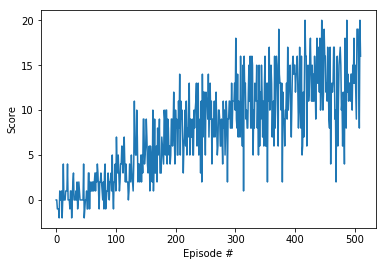

In [4]:
import dqn_agent
agent = dqn_agent.Agent(state_size=37, action_size=4, seed=0)
scores = dqn(agent, weights_file='./weights/dqn.pth')

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

The neural network consists of **two hidden layers** with **RELU** activation functions. We have 64 hidden units in each layer. 

# Double-DQN

The double-DQN algorithm is based on DQN, but tackles one specific problem: the estimate of the action-value function that DQN produces is biased. This means that the esimated value $\hat q(s, a)$ is expeceted to be larger than the true action-value function $q(s, a)$. This can be easily seen by staring at the update equation

$$\hat q(s, a) \rightarrow \hat q(s, a) + \alpha \left(r + \gamma \max_{a'} \hat q(s_{next}, a')  - q(s, a)\right) \:.$$

The observation here, first made in [6], is that $\hat q(s, a')$ is a noisy estimate of $q(s, a)$, with different noise for different actions $a \in \mathcal A$. If we write $\hat q(s, a') = q(s, a) + \delta_{s, a}$ where $\delta$ represents this noise, part of the $\max$ operation just maximizes over the noise.

A solution to this bias problem, suggested in [3, 7] is to fit **two independent** function approximators, $f_i: \mathcal S \times \mathcal A \rightarrow \mathbb R, i = 1, 2$. The above update equation then reads as

$$f_1(s, a) \rightarrow f_1(s, a) + \alpha \left(r + \gamma f_1\left(\arg\max_a f_2(s_{next})\right) - f_1(s, a)\right) \:,$$

i.e. we use $f_2$ to calculate the best actino and then update $f_1$ using this best action. Then, we switch the roles of $f_1$ and $f_2$ ensuring that each network remains a good estimator of the state-value function $q(s, a)$.

The paper [3] actually simplifies this update step and uses the **target network** from DQN to calculate the best action. This means that the update equation reads as

$$q_{local}(s, a) \rightarrow q_{local} + \alpha \left(r + \gamma q_{local}\left(\arg\max_a q_{target}(s_{next})\right) - q_{local}(s, a)\right) \:.$$

Except for this change, the algorithm is the same as the original DQN.

Episode 100	Average Score: 0.74 	Total time 139.01
Episode 200	Average Score: 3.83 	Total time 283.55
Episode 300	Average Score: 7.03 	Total time 430.39
Episode 400	Average Score: 9.26 	Total time 576.25
Episode 500	Average Score: 12.83 	Total time 722.57
Episode 510	Average Score: 13.07 	Total time 737.14


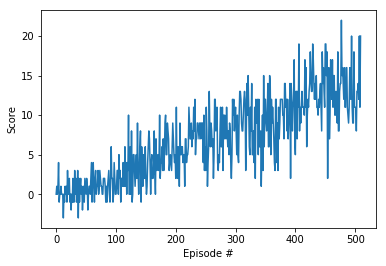

In [7]:
import double_dqn
agent = double_dqn.Agent(state_size=37, action_size=4, seed=0)
scores = dqn(agent, weights_file='./weights/double_dqn.pth')

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

# Prioritized experience replay

The idea of *prioritized experience replay* is that some experiences are more important than others. These more important experiences should be sampled more frequently. The importance of an observation comes from its *TD-error*

$$
\delta_t = R_{t+1} + \gamma \max_a \hat q(S_{†+1},a , w) - \hat q (S_t, A_t, w) \:.
$$

In this report, *rank-based prioritized experience replay* was implemented, meaning that the probability $p_i$ of being sampled is 

$$
p_i = \frac{1}{rank_i}
$$

for experience $i$, where $rank_i$ denotes the rank of the TD error among all experiences.

Episode 100	Average Score: 0.47 	Total time 99.24
Episode 200	Average Score: 4.00 	Total time 227.33
Episode 300	Average Score: 7.50 	Total time 386.28
Episode 400	Average Score: 8.46 	Total time 572.59
Episode 500	Average Score: 11.19 	Total time 760.49
Episode 583	Average Score: 13.02 	Total time 914.34


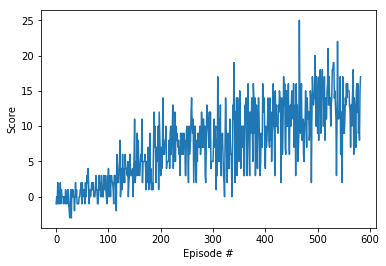

In [14]:
import rank_priorization
agent = rank_priorization.Agent(state_size=37, action_size=4, seed=0)
scores = dqn(agent, weights_file='./weights/prioritized.pth')

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

# Summary

We don't see a difference between basic DQN, double DQN and proritized experience replay with double DQN. More experiments and hyperparameters have to be performed to further investigate this. 

As an example of how the double DQN agent performed, see this video:

[![IMAGE ALT TEXT HERE](https://img.youtube.com/vi/rT_opLZS6SI/0.jpg)](https://www.youtube.com/watch?v=rT_opLZS6SI)

# Further improvements

There's several other interesting improvements to be made:



+ Noisy DQN [8]: This is an interesting variation where the exploration mainly comes from adding noise to the weights of the neural network.
+ Asynchronous learning [9]: here we have several learners that interact with a common target network. This allows for more efficient exploration.
+ Model the distribution of returns [10]
+ Fianlly, we can combine all of the improvements to the basic DQN algorithm. This is then called *Rainbow DQN* [11].

A different route of exploration uses Bayesian optimization [5] for hyperparameter optimization. Bayesian optimization is a black box algorithm that uses the hyperparameters tried so far very efficiently to optimize on them. Using this allows fair comparisons between the various algorithms.

# References

1. Snoek, Jasper, Hugo Larochelle, and Ryan P. Adams. "Practical bayesian optimization of machine learning algorithms." Advances in neural information processing systems. 2012.
2. Mnih, Volodymyr, et al. "Human-level control through deep reinforcement learning." Nature 518.7540 (2015): 529.
3. Van Hasselt, Hado, Arthur Guez, and David Silver. "Deep Reinforcement Learning with Double Q-Learning." AAAI. Vol. 2. 2016.
4. Schaul, Tom, et al. "Prioritized experience replay." arXiv preprint arXiv:1511.05952 (2015).
5. Bergstra, James, and Yoshua Bengio. "Random search for hyper-parameter optimization." Journal of Machine Learning Research 13.Feb (2012): 281-305.
6. Thrun, Sebastian, and Anton Schwartz. "Issues in using function approximation for reinforcement learning." Proceedings of the 1993 Connectionist Models Summer School Hillsdale, NJ. Lawrence Erlbaum. 1993.
7. Hasselt, Hado V. "Double Q-learning." Advances in Neural Information Processing Systems. 2010.
8. Fortunato, Meire, et al. "Noisy networks for exploration." arXiv preprint arXiv:1706.10295 (2017).
9. Mnih, Volodymyr, et al. "Asynchronous methods for deep reinforcement learning." International conference on machine learning. 2016.
10. Bellemare, Marc G., Will Dabney, and Rémi Munos. "A distributional perspective on reinforcement learning." arXiv preprint arXiv:1707.06887 (2017).
11. Hessel, Matteo, et al. "Rainbow: Combining improvements in deep reinforcement learning." arXiv preprint arXiv:1710.02298 (2017).

In [4]:
env.close()